In [1]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()

import sys
import os
import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
train_df = pd.read_parquet('../../data/final_features_ml/train_all_features_last_month.parquet')
val_df = pd.read_parquet('../../data/final_features_ml/val_all_features_last_month.parquet')
test_df = pd.read_parquet('../../data/final_features_ml/test_all_features_last_month.parquet')

In [4]:
y_train = pd.read_parquet('../../data/3d_array/train_targets.parquet')
y_val = pd.read_parquet('../../data/3d_array/val_targets.parquet')
y_test = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_df.sort_values(by = ['customer_ID'], inplace=True)
y_train.sort_values(by = ['customer_ID'], inplace=True)
val_df.sort_values(by = ['customer_ID'], inplace=True)
y_val.sort_values(by = ['customer_ID'], inplace=True)
test_df.sort_values(by = ['customer_ID'], inplace=True)
y_test.sort_values(by = ['customer_ID'], inplace=True)

In [6]:
train_df.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [7]:
# #Load ML model
# import pickle
# with open('../../models/machine_learning/eec_xgb_tuned.pkl', 'rb') as f:
#     model = pickle.load(f)

In [8]:
best_hyperparameters = {'colsample_bylevel': 0.7034102067004069,
 'colsample_bynode': 0.8390472679574996,
 'colsample_bytree': 0.6579388820591151,
 'device': 'cuda',
 'gamma': 0.8748685189195721,
 'learning_rate': 0.03865122131423628,
 'max_depth': 6,
 'min_child_weight': 6.0,
 'n_estimators': 800,
 'random_state': 0,
 'reg_alpha': 0.01227859576937017,
 'reg_lambda': 8.80210770131299,
 'scale_pos_weight': 3.936315894379681,
 'subsample': 0.6258062584859616,
 'tree_method': 'hist'}

In [9]:
from xgboost import XGBClassifier
model = XGBClassifier(**best_hyperparameters)
model.fit(train_df.drop(columns = ['customer_ID']), y_train['target'].values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.7034102067004069,
              colsample_bynode=0.8390472679574996,
              colsample_bytree=0.6579388820591151, device='cuda',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.8748685189195721,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03865122131423628,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=6.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=800, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

In [40]:
explainer = shap.TreeExplainer(model, train_df.drop(columns=['customer_ID']).values, model_output='probability')

In [11]:
# shap_values = explainer(val_df.drop(columns=['customer_ID']))

In [12]:
#save shap values in pickle
# import pickle
# with open('../../models/shap/shap_values_val.pkl', 'wb') as f:
#     pickle.dump(shap_values, f)

In [13]:
import pickle
shap_values_load = pickle.load(open('../../models/shap/shap_values_val.pkl', 'rb'))

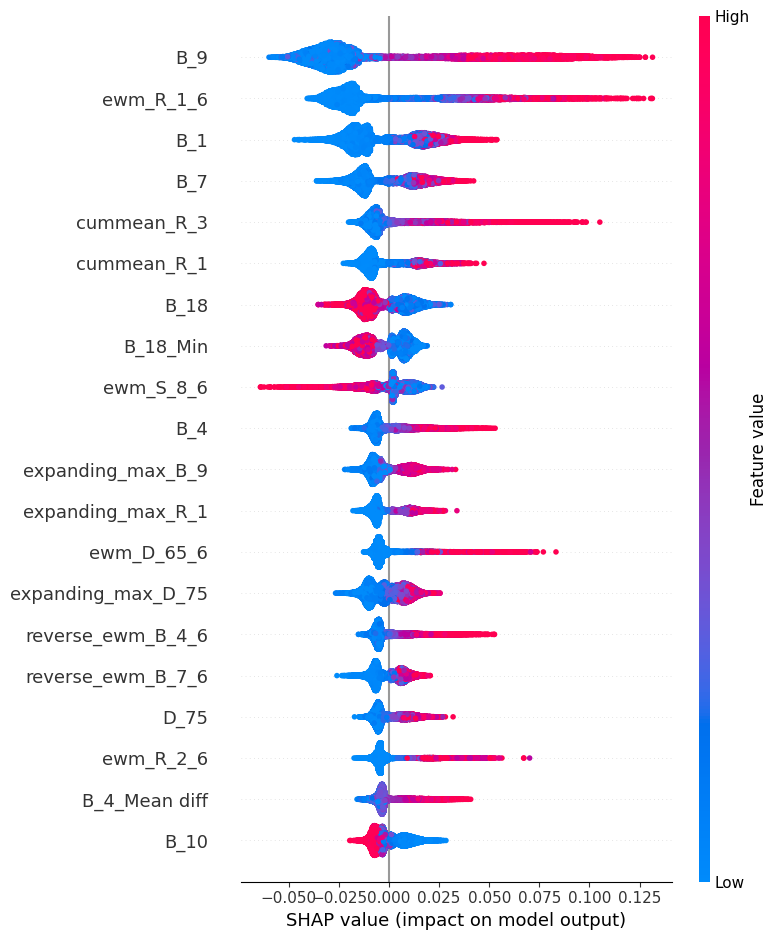

In [14]:
shap.summary_plot(shap_values_load, max_display=20, show=True)

In [15]:
from utils.threshold import find_threshold_binary_search
threshold, _ = find_threshold_binary_search(y_true=y_val['target'].values, y_pred_proba = model.predict_proba(val_df.drop(columns=['customer_ID']))[:,1])

c:\Users\vaseekaranv\AppData\Local\anaconda3\envs\nibm_dl\lib\site-packages\xgboost\core.py:158: UserWarning: [17:40:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.9199536
Achieved Recall at Threshold: 0.9800


In [16]:
threshold

0.9199535846710205

In [17]:
#Get predictions based on the threshold
y_pred = model.predict_proba(val_df.drop(columns=['customer_ID']))[:,1] > threshold

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_val['target'].values, y_pred, target_names=['0', '1'], digits = 4))

              precision    recall  f1-score   support

           0     0.8653    0.9800    0.9191     23806
           1     0.9078    0.5634    0.6953      8318

    accuracy                         0.8721     32124
   macro avg     0.8865    0.7717    0.8072     32124
weighted avg     0.8763    0.8721    0.8611     32124



In [19]:
pred_df = pd.DataFrame({'customer_ID': val_df['customer_ID'].values, 'target': y_val['target'].values, 'pred': y_pred.astype(int)})

In [20]:
pred_default_pred_df = pred_df[pred_df['pred'] == 1]
pred_non_default_pred_df = pred_df[pred_df['pred'] == 0]

In [21]:
type(shap_values_load)

shap._explanation.Explanation

In [22]:
shap_values_load[:10, :]

.values =
array([[ 7.78194715e-04,  3.08992086e-03, -1.49785610e-03, ...,
        -8.76434342e-05,  8.06343789e-04, -1.20371728e-03],
       [-8.21626534e-03, -1.91564295e-02, -2.77602936e-03, ...,
        -9.98327714e-04,  1.63633096e-04,  2.21567652e-04],
       [-5.05775262e-03, -2.07041923e-02, -3.16355311e-03, ...,
        -4.34265272e-04,  1.16722132e-03, -6.43704712e-04],
       ...,
       [-3.81776610e-03, -1.85145147e-02, -1.73052016e-03, ...,
        -1.88954087e-04,  1.12602490e-04, -3.20686757e-04],
       [-1.67163447e-03,  1.38712596e-02, -2.35583392e-03, ...,
        -4.77028573e-05,  1.50558314e-03,  7.25564465e-05],
       [-6.91697273e-04, -1.67594520e-02, -4.51893140e-04, ...,
        -1.13718409e-04, -1.77948414e-03, -8.54823722e-04]])

.base_values =
array([0.39447074, 0.39447074, 0.39447074, 0.39447074, 0.39447074,
       0.39447074, 0.39447074, 0.39447074, 0.39447074, 0.39447074])

.data =
array([[ 1.86344057e-01,  5.40172905e-02,  9.12129879e-03, ...,
         

In [23]:
np.array(pred_default_pred_df.index)

array([    0,     5,    25, ..., 32106, 32109, 32121], dtype=int64)

In [24]:
# save shap values for the real default and non-default predictions
shap_values_pred_default = shap_values_load[np.array(pred_default_pred_df.index), :]
shap_values_pred_non_default = shap_values_load[np.array(pred_non_default_pred_df.index), :]
shap_values_pred_default.shape, shap_values_pred_non_default.shape

((5162, 425), (26962, 425))

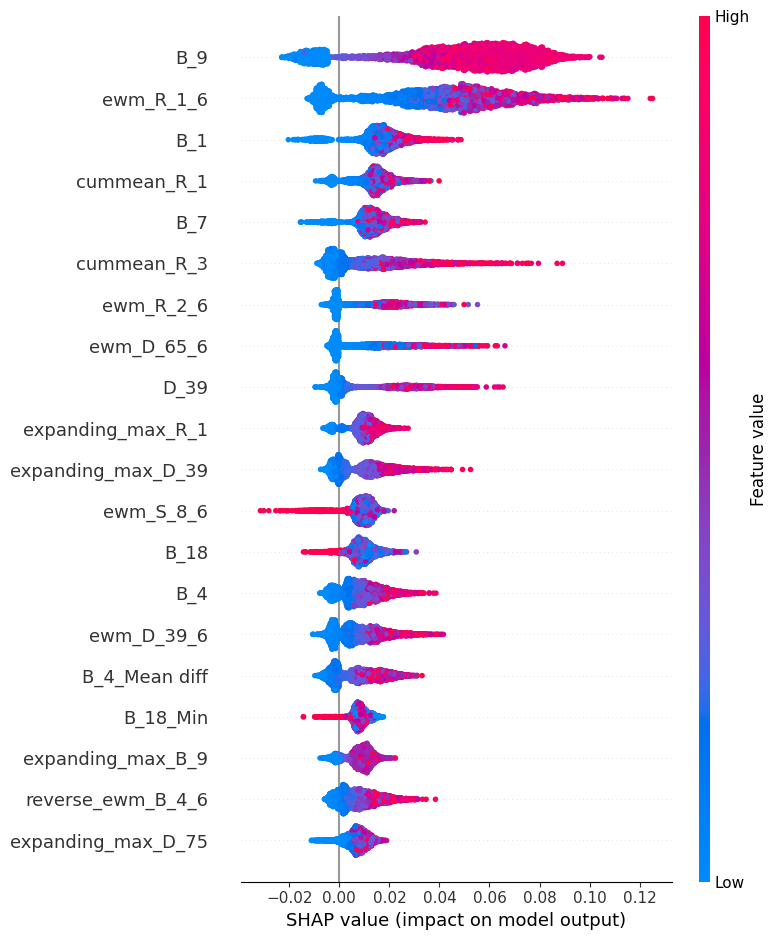

In [37]:
#shap summary for default predictions
shap.summary_plot(shap_values_pred_default, max_display=20, show=True)

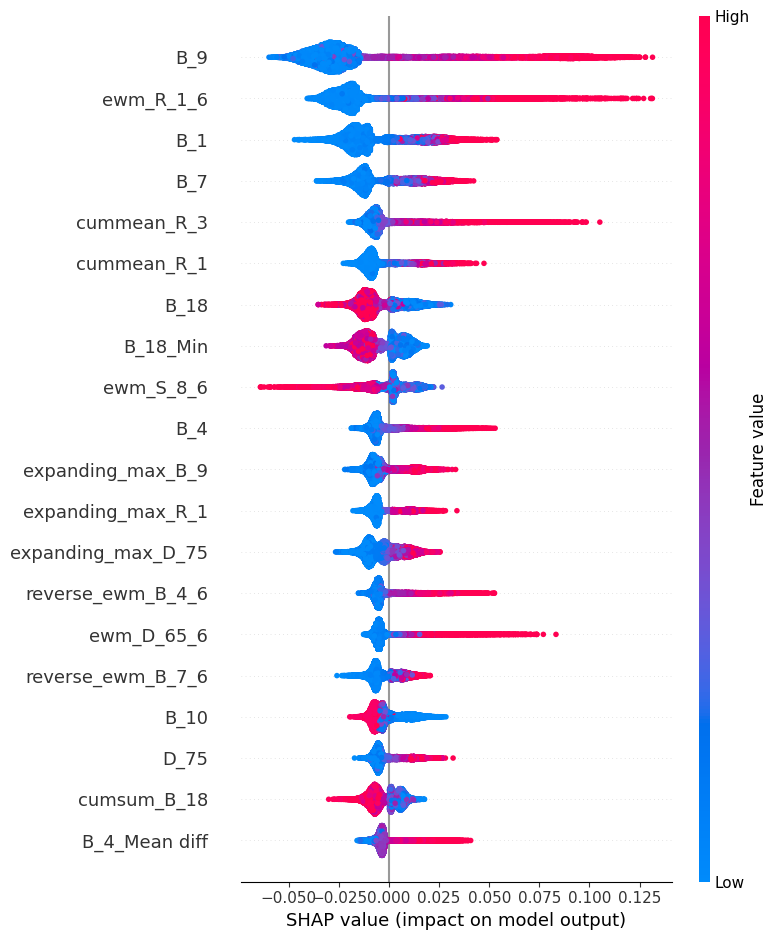

In [39]:
shap.summary_plot(shap_values_pred_non_default, max_display=20, show=True, title = 'True Negatives')

In [25]:
true_positives_df = pred_default_pred_df[pred_default_pred_df['target'] == 1]
true_negatives_df = pred_non_default_pred_df[pred_non_default_pred_df['target'] == 0]

false_positives_df = pred_default_pred_df[pred_default_pred_df['target'] == 0]
false_negatives_df = pred_non_default_pred_df[pred_non_default_pred_df['target'] == 1]

In [26]:
true_positives_df.shape, true_negatives_df.shape, false_positives_df.shape, false_negatives_df.shape

((4686, 3), (23330, 3), (476, 3), (3632, 3))

In [27]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val['target'].values, y_pred, labels=[0, 1]))

[[23330   476]
 [ 3632  4686]]


In [28]:
#filter the shap values for the true positives, true negatives, false positives and false negatives
shap_values_true_positives = shap_values_load[np.array(true_positives_df.index), :]
shap_values_true_negatives = shap_values_load[np.array(true_negatives_df.index), :]
shap_values_false_positives = shap_values_load[np.array(false_positives_df.index), :]
shap_values_false_negatives = shap_values_load[np.array(false_negatives_df.index), :]
shap_values_true_positives.shape, shap_values_true_negatives.shape, shap_values_false_positives.shape, shap_values_false_negatives.shape

((4686, 425), (23330, 425), (476, 425), (3632, 425))

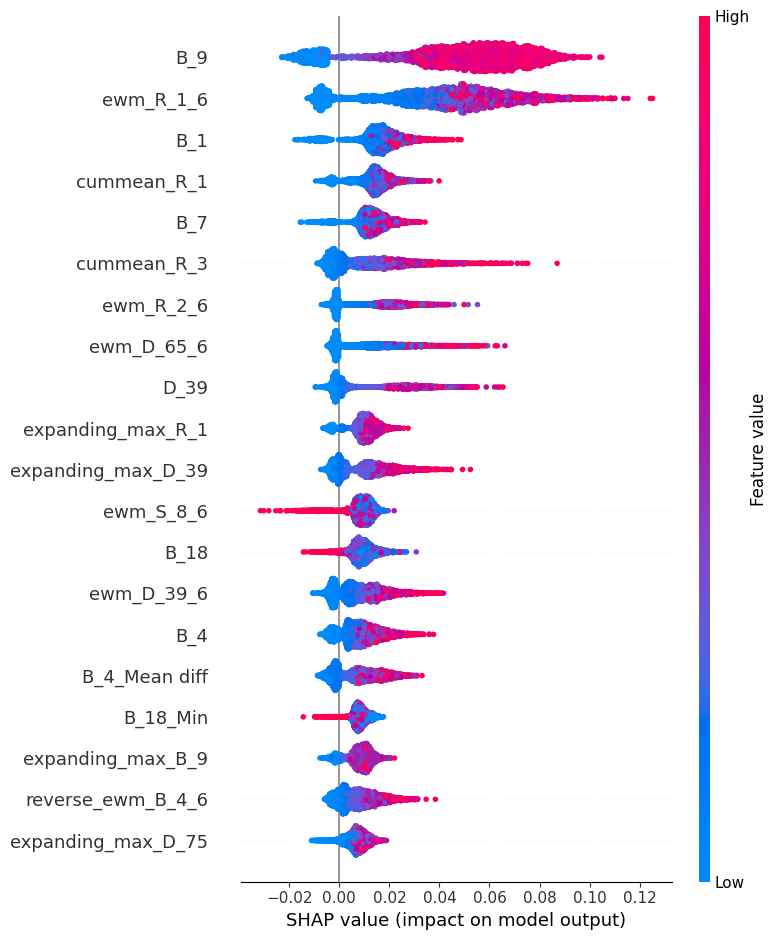

In [30]:
#plot summary plot for predicted positives and real negatives
shap.summary_plot(shap_values_true_positives, max_display=20, show=True, title = 'True Positives')

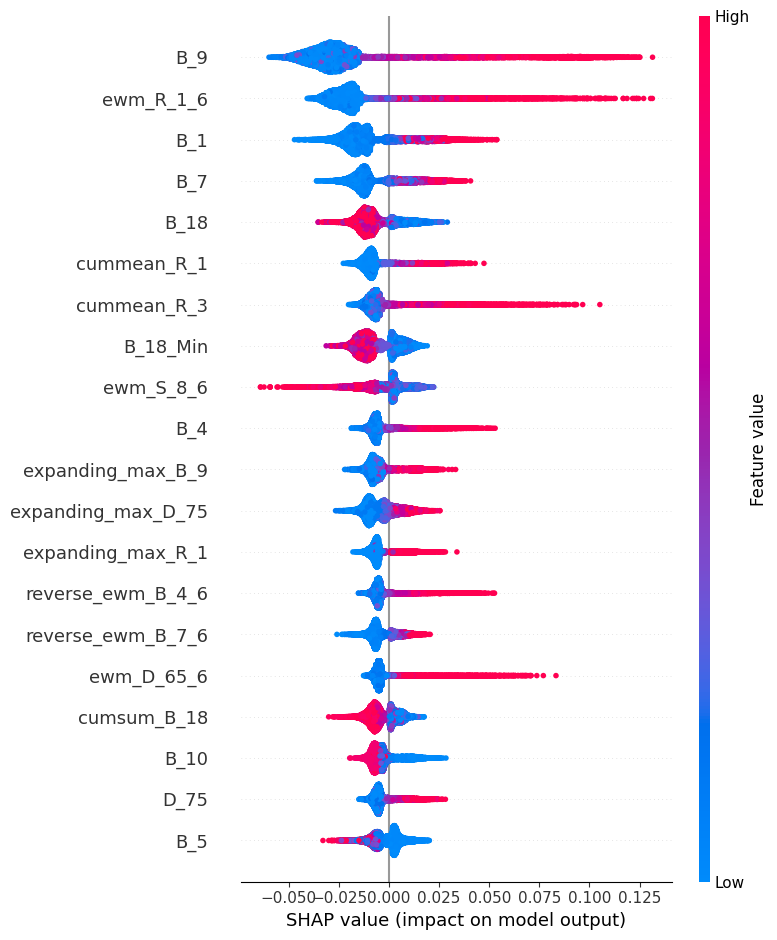

In [31]:
shap.summary_plot(shap_values_true_negatives, max_display=20, show=True, title = 'True Negatives')

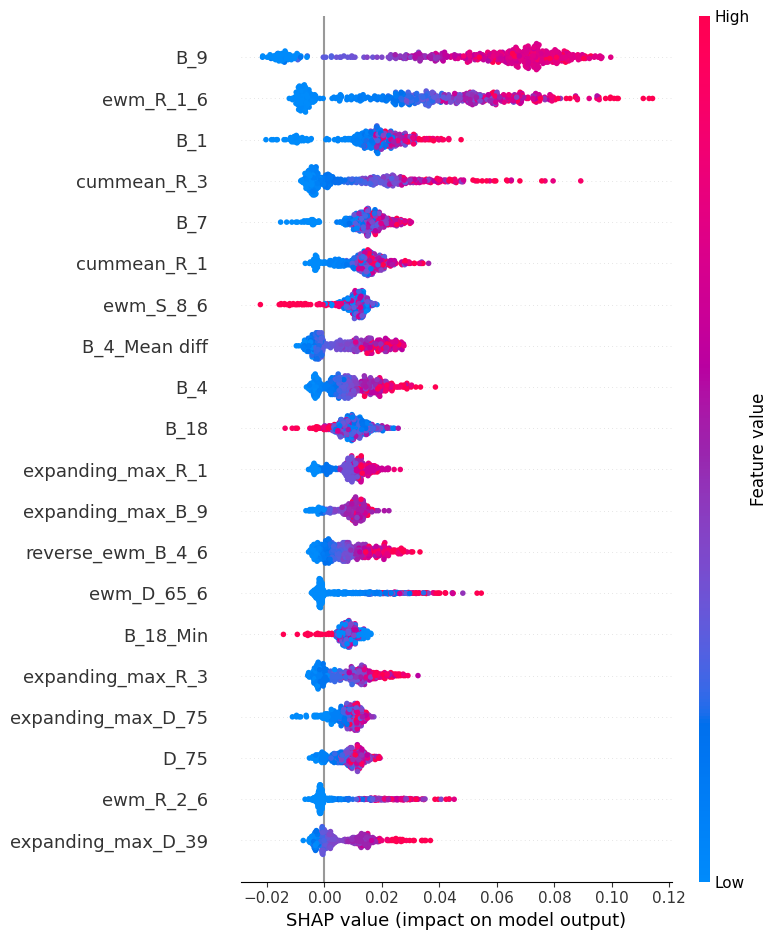

In [33]:
#plot for false positives and false negatives
shap.summary_plot(shap_values_false_positives, max_display=20, show=True, title = 'False Positives')

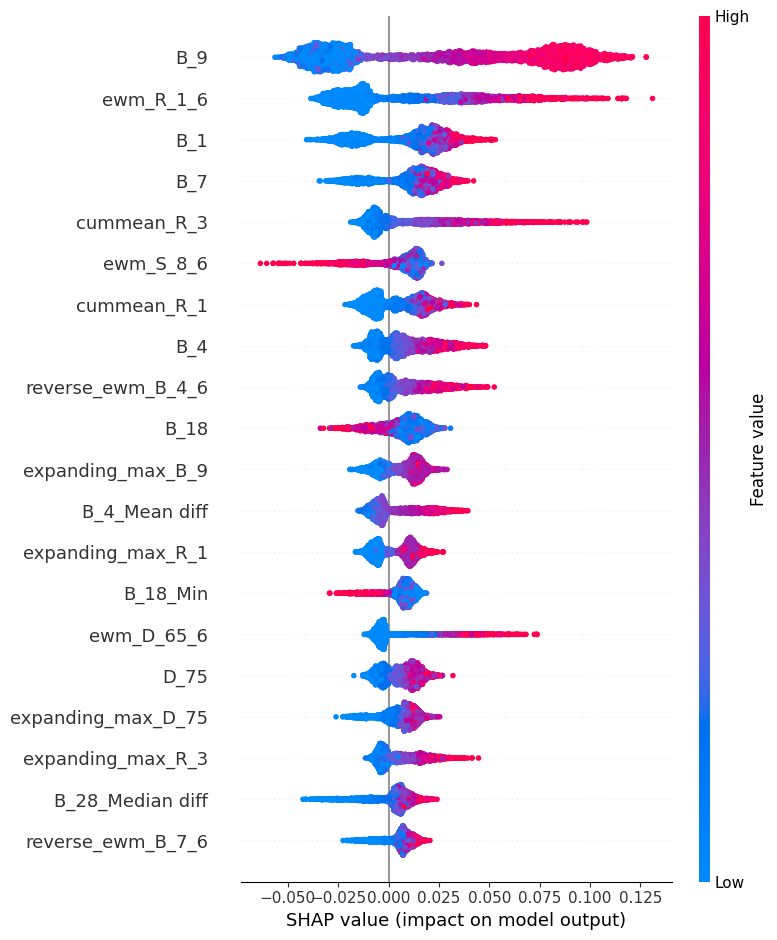

In [34]:
shap.summary_plot(shap_values_false_negatives, max_display=20, show=True, title = 'False Positives')

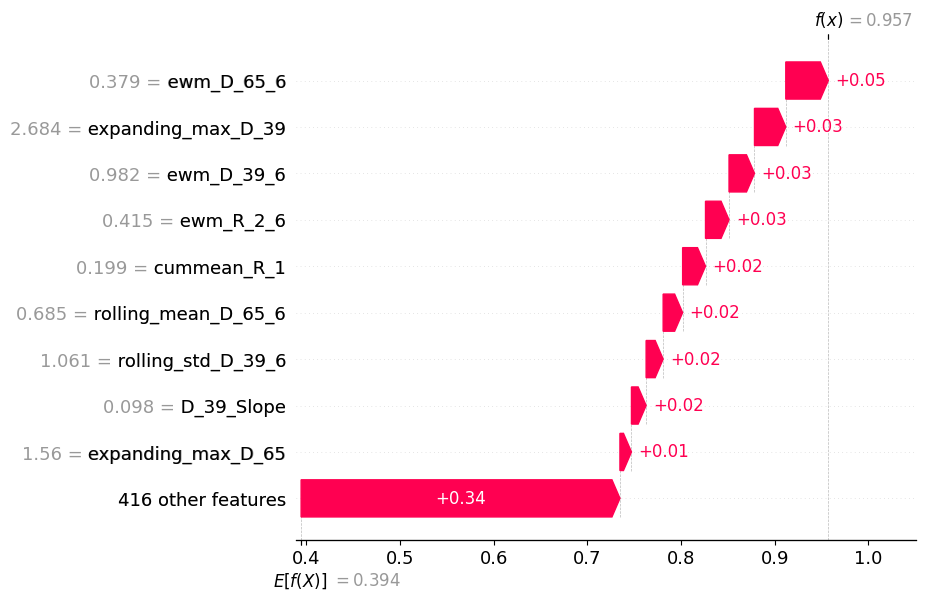

In [42]:
#waterfall for true positive
shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_true_positives[0], base_values=explainer.expected_value, data=val_df.drop(columns=['customer_ID']).values[0], feature_names=val_df.drop(columns=['customer_ID']).columns.tolist()))

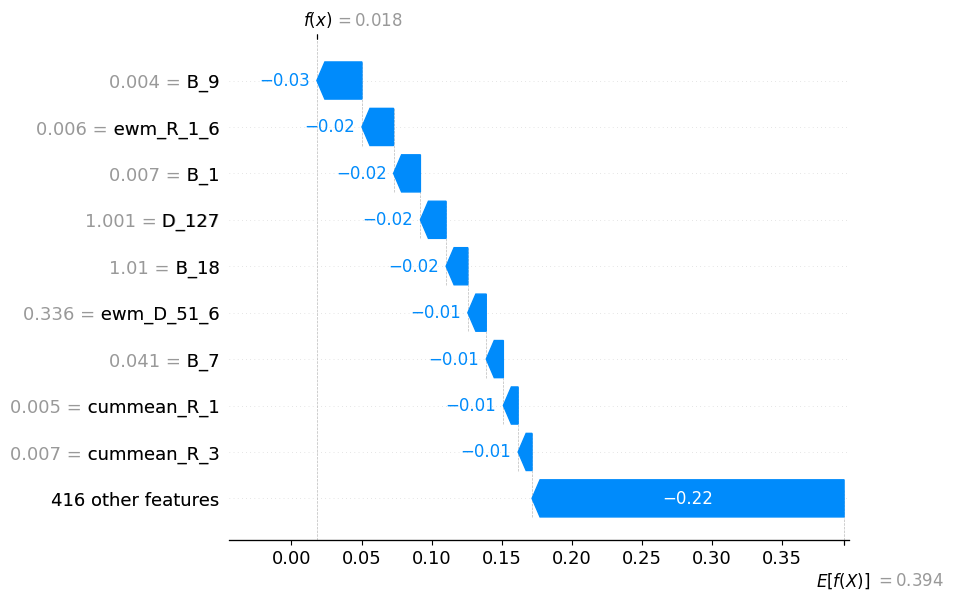

In [43]:
#true negative waterfall
shap.waterfall_plot(shap.Explanation(values=shap_values_true_negatives[0], base_values=explainer.expected_value, data=val_df.drop(columns=['customer_ID']).values[0], feature_names=val_df.drop(columns=['customer_ID']).columns.tolist()))

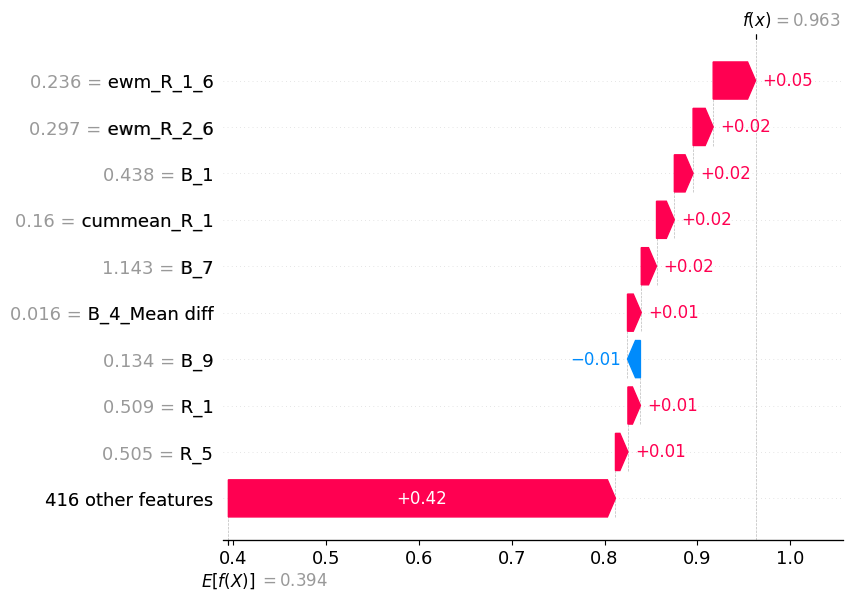

In [44]:
#false positives
shap.waterfall_plot(shap.Explanation(values=shap_values_false_positives[0], base_values=explainer.expected_value, data=val_df.drop(columns=['customer_ID']).values[0], feature_names=val_df.drop(columns=['customer_ID']).columns.tolist()))

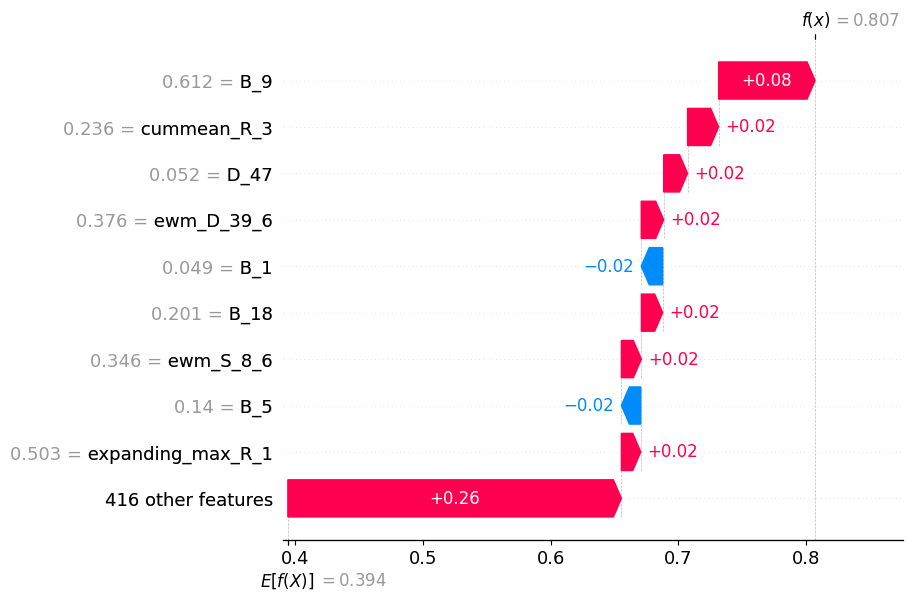

In [45]:
#false negative
shap.waterfall_plot(shap.Explanation(values=shap_values_false_negatives[0], base_values=explainer.expected_value, data=val_df.drop(columns=['customer_ID']).values[0], feature_names=val_df.drop(columns=['customer_ID']).columns.tolist()))